In [240]:
import os
from collections import Counter
from itertools import product
from statistics import mean, mode, median

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.tokenize import TweetTokenizer, word_tokenize
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from torch import optim
from tqdm.auto import tqdm
from transformers import AutoModel
from transformers import BertModel, RobertaModel, AlbertModel, BartForSequenceClassification
from transformers import BertTokenizerFast, RobertaTokenizerFast, AlbertTokenizerFast, BartTokenizer

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/anna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
names = ['id', 'json', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'credit', 'barely_true',
         'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context', 'justification']
df = pd.read_csv('LIAR-PLUS-master/dataset/tsv/train2.tsv', sep='\t', names=names)

In [8]:
df['label'].value_counts()

half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64

In [19]:
texts = list(df[df['label'] == 'true']['statement']) + list(df[df['label'] == 'false']['statement'])
labels = list(df[df['label'] == 'true']['label']) + list(df[df['label'] == 'false']['label'])

In [24]:
import random

temp = list(zip(texts, labels))
random.shuffle(temp)
texts, labels = zip(*temp)

In [25]:
lengths = [len(text) for text in texts]

In [26]:
print(sorted(lengths, reverse=True))

[2155, 1641, 1109, 851, 370, 342, 311, 293, 288, 276, 269, 267, 257, 253, 253, 252, 249, 247, 243, 243, 243, 242, 242, 241, 241, 238, 237, 236, 233, 233, 233, 232, 231, 231, 230, 230, 230, 230, 228, 228, 228, 228, 227, 227, 226, 225, 225, 225, 224, 224, 223, 223, 222, 222, 222, 222, 221, 220, 219, 219, 219, 218, 217, 217, 217, 217, 217, 217, 216, 216, 215, 215, 215, 214, 214, 214, 214, 214, 214, 213, 212, 212, 211, 211, 211, 211, 210, 210, 210, 210, 209, 209, 209, 209, 208, 208, 208, 208, 207, 207, 207, 207, 206, 206, 206, 205, 205, 205, 204, 204, 203, 203, 203, 202, 202, 202, 202, 202, 201, 201, 200, 200, 200, 200, 200, 199, 199, 199, 198, 198, 198, 198, 197, 197, 197, 197, 197, 196, 196, 196, 196, 196, 195, 195, 194, 194, 194, 194, 193, 193, 193, 193, 193, 193, 192, 192, 192, 192, 191, 191, 191, 190, 190, 189, 189, 189, 189, 189, 189, 189, 188, 188, 188, 188, 187, 187, 187, 187, 187, 186, 186, 186, 185, 185, 185, 185, 184, 184, 184, 184, 184, 183, 183, 183, 183, 183, 183, 183, 182, 1

In [29]:
print(f"median: {median(lengths)}\nmode: {1}\nmean: {round(mean(lengths))}\nmax: {max(lengths)}\nmin: {min(lengths)}")


median: 95
mode: 1
mean: 104
max: 2155
min: 11


In [30]:
tokenize = TweetTokenizer()

In [59]:
ready_texts = [tokenize.tokenize(text) for text in texts]
ready_labels = [1 if label == 'true' else 0 for label in labels]

In [71]:
X_train, X_test, y_train, y_test = train_test_split(ready_texts, ready_labels, test_size=0.1)

In [72]:
len(X_train), len(y_train), len(X_test), len(y_test)

(3303, 3303, 368, 368)

In [73]:
X_train, y_train, X_val, y_val = X_train[368:], y_train[368:], X_train[:368], y_train[:368]

In [74]:
c = Counter(y_train)
print(f"Number of positive examples: {c[0]}\nNumber of negative examples: {c[1]}")

Number of positive examples: 1577
Number of negative examples: 1358


In [75]:
lengths = [len(x) for x in X_train]
print(
    f"median: {median(lengths)}\nmode: {mode(lengths)}\nmean: {round(mean(lengths))}\nmax: {max(lengths)}\nmin: {min(lengths)}")

median: 18
mode: 17
mean: 20
max: 279
min: 2


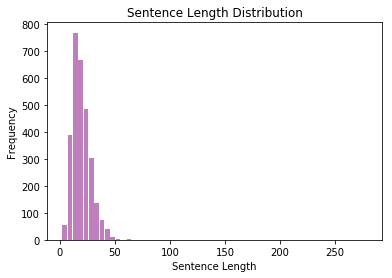

In [86]:
data = lengths
num_bins = 57
plt.hist(data, num_bins, color='purple', alpha=0.5, rwidth=0.85)
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [76]:
word2token = {'PAD': 0, 'UNK': 1}
all_words = set()
for text in X_train:
    for word in text:
        all_words.add(word)
for word in all_words:
    word2token[word] = len(word2token)

In [103]:
class RNNclassifier(nn.Module):
    def __init__(self, device, emb_size, num_classes=1, dropout=0.4, hidden_size=100):
        super(RNNclassifier, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.emb_size = emb_size
        self.dropout = nn.Dropout(dropout).to(self.device)
        self.num_classes = num_classes
        self.embedding = nn.Embedding(self.emb_size, self.hidden_size).to(self.device)
        self.rnn = nn.RNN(self.hidden_size, self.hidden_size, batch_first=True).to(self.device)
        self.linear = nn.Linear(self.hidden_size, self.num_classes).to(self.device)

    def forward(self, tokens, attention_ids, length):
        embs = self.embedding(tokens)
        rnn_out, hidden = self.rnn(embs)
        drop_out = self.dropout(rnn_out)
        output_zero_padding = drop_out.permute([2, 0, 1]) * attention_ids
        output_zero_padding = output_zero_padding.permute([1, 2, 0])
        out = torch.sum(output_zero_padding, 1).T / length
        out = out.T
        out = self.linear(out)
        return out

In [141]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, maxlen, word2token, device):
        self.texts = texts
        self.labels = labels
        self.device = device
        self.maxlen = maxlen
        self.word2token = word2token

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        transformed_text = [self.word2token.get(word, 1) for word in text][:self.maxlen]
        transformed_text = torch.tensor(
            transformed_text + [self.word2token['PAD'] for _ in range(self.maxlen - len(transformed_text))],
            dtype=torch.long, device=self.device)
        attention_ids = torch.tensor(
            [1 for _ in range(len(transformed_text))] + [0 for _ in range(self.maxlen - len(transformed_text))],
            dtype=torch.long, device=self.device)
        return transformed_text, len(transformed_text), attention_ids, label

    def __len__(self):
        return len(self.texts)

In [222]:
def train_model(model, dataloader, dev_dataloader, epoches, optim=optim.RMSprop, lr=0.01):
    optimizer = optim(model.parameters(), lr=lr)  # Adam, AdamW, Adadelta, Adagrad, SGD, RMSProp
    binary = nn.BCEWithLogitsLoss()
    best_f = 0
    for epoch in range(epoches):
        print(epoch + 1, "epoch")
        t = tqdm(dataloader)
        i = 0
        for sentence, length, attention_ids, label in t:
            pred = model(sentence, attention_ids, length)
            loss = binary(pred.view(-1), label.type(torch.float32))
            if i % 10 == 0:
                torch.save(model, 'model.pt')
                predicted = []
                true = []
                with torch.no_grad():
                    for sentence, length, attention_ids, label in dev_dataloader:
                        pred = model(sentence, attention_ids, length)
                        idx = (torch.sigmoid(pred) > 0.5).type(torch.int).item()
                        predicted.append(idx)
                        true.append(label.item())
                f1 = f1_score(true, predicted, average='macro')
                if f1 > best_f:
                    torch.save(model, f"{round(f1, 3)}model.pt")
                    best_f = f1
                    print("Saving with score", best_f)
            i += 1
            t.set_description(f"loss: {round(float(loss), 3)}, f-macro: {round(f1, 3)}")
            t.refresh()
            loss.backward()
            optimizer.step()
            model.zero_grad()
    return best_f

In [143]:
trainds = Dataset(X_train, y_train, 50, word2token, device)
devds = Dataset(X_val, y_val, 50, word2token, device)
testds = Dataset(X_test, y_test, 50, word2token, device)

In [144]:
train_dataloader = torch.utils.data.DataLoader(trainds, batch_size=128)
dev_dataloader = torch.utils.data.DataLoader(devds, batch_size=1)
test_dataloader = torch.utils.data.DataLoader(testds, batch_size=1)

In [181]:
model = RNNclassifier(device, len(word2token), 1, 0.4, 100)
model.train()
train_model(model, train_dataloader, dev_dataloader, epoches=10)

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.3467363146048329
Saving with score 0.36761808960979087
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.36878216123499147
Saving with score 0.5134971454737478
3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5370380020099006
5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5478844540333213
10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5828838766117683


In [224]:
def param_optim(lr_list, optim_list):
    best_f = 0
    best_params = []
    for lr, optim in product(lr_list, optim_list):
        model = RNNclassifier(device, len(word2token), 1, 0.4, 100)
        model.train()
        f1 = train_model(model, train_dataloader, dev_dataloader, epoches=10, optim=optim, lr=lr)
        if best_f < f1:
            best_f = f1
            best_params = [lr, optim]
    return best_f, best_params

In [219]:
lr_list = [0.1, 0.01, 0.001, 0.0001]
op_list = [optim.Adam, optim.AdamW, optim.Adadelta, optim.Adagrad, optim.SGD, optim.RMSprop]

(0.5148437499999999, [0.1, torch.optim.rmsprop.RMSprop])

In [225]:
best_f, best_params = param_optim(lr_list, op_list)

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.3829644533869886
Saving with score 0.3893741586049278
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.4490351978425629
Saving with score 0.5301874595992244
Saving with score 0.532608695652174
3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5481524383180818
4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.45873391582166895
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5071797372719321
3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5645102560990412
5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.3844942935852027
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.3955586702290745
3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.3958724202626641
5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.39975155279503105
7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.40199761941727474
8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.410064935064935
1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.3062720225510923
Saving with score 0.32649151614668853
Saving with score 0.377033374813619
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5340661959662765
3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5671276426641234
4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.4608561306305107
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.4663229133097002
9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.4767140951926728
10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.2909441233140655
Saving with score 0.43609661366670716
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.4882088059959556
3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.44934909471794104
Saving with score 0.5295483243531525
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5319506213890852
4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5818181818181818
5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5846765220155777
6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5892857142857142
7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.29609294746909426
Saving with score 0.3992546124703539
Saving with score 0.5085112066244142
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5166490212779506
Saving with score 0.5286502074656971
3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5538360554461562
Saving with score 0.5702447608382659
Saving with score 0.5818181818181818
4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5860905426937857
5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.2909441233140655
Saving with score 0.29609294746909426
Saving with score 0.33884745762711865
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.4034411915767848
Saving with score 0.482717803030303
Saving with score 0.49348371518683687
3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.36986301369863017
Saving with score 0.377033374813619
Saving with score 0.4309450895970407
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5295483243531525
3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5413862642467089
4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5552452801861653
Saving with score 0.5630269672822865
5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5688182249644045
6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5770892709386779
7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5794543767208915
9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.4187668612351008
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.3838509316770186
Saving with score 0.47672765191013367
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5301075268817204
6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.547911547911548
8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5525594853325946
1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.37094017094017095
Saving with score 0.3781542898341745
Saving with score 0.3997825299021384
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.46070708921047815
3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.47021364917022157
Saving with score 0.4877470355731226
5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5059767361473967
Saving with score 0.5172504263413354
6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5360710156279139
7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5370380020099006
Saving with score 0.5429956080569438
Saving with score 0.5509576104833148
8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5539326773224517
9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.39237243767870805
Saving with score 0.4971006463527239
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5100985127990567
6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5328111659675563
7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5495787633126689
8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5589488636363635
9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.558953362861503
Saving with score 0.5764601864343478
10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5883668903803132
1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.44895133872653814
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [226]:
best_f, best_params

(0.5148437499999999, [0.1, torch.optim.rmsprop.RMSprop])

In [154]:
model.eval()

RNNclassifier(
  (dropout): Dropout(p=0.4, inplace=False)
  (embedding): Embedding(7772, 100)
  (rnn): RNN(100, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [170]:
def evaluate(model, test_dataloader):
    predicted = []
    true = []
    with torch.no_grad():
        for sentence, length, attention_ids, label in test_dataloader:
            pred = model(sentence, attention_ids, length)
            idx = (torch.sigmoid(pred) > 0.5).type(torch.int).item()
            predicted.append(idx)
            true.append(label.item())
    print(classification_report(true, predicted))

In [171]:
evaluate(torch.load('0.595model.pt'), test_dataloader)

             precision    recall  f1-score   support

          0       0.62      0.67      0.64       201
          1       0.56      0.51      0.54       167

avg / total       0.60      0.60      0.60       368



In [172]:
class CNNclassifier(nn.Module):
    def __init__(self, device, maxlen, max_pool, emb_size, num_classes=2, hidden_size=100):
        super(CNNclassifier, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.maxlen = maxlen
        self.max_pool = max_pool
        self.emb_size = emb_size
        self.embedding = nn.Embedding(self.emb_size, self.hidden_size).to(self.device)
        self.cnn = nn.Conv1d(self.hidden_size, int(self.hidden_size / 2), 3)
        self.maxpool = nn.MaxPool1d(int(self.maxlen - 2))
        self.linear = nn.Linear(int((self.hidden_size / 2)), num_classes).to(self.device)

    def forward(self, tokens, attention_ids, length):
        embs = self.embedding(tokens)
        embs = embs.permute(0, 2, 1)
        cnn_out = self.cnn(embs)
        max_out = self.maxpool(cnn_out)
        max_out = max_out.permute(0, 2, 1)
        out = self.linear(max_out)
        out = out.squeeze(1)
        return out

In [227]:
cn = CNNclassifier(device, 50, 3, len(word2token), 1)
cn.train()

CNNclassifier(
  (embedding): Embedding(7772, 100)
  (cnn): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=48, stride=48, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [228]:
train_model(cn, train_dataloader, dev_dataloader, 10)

1 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.49747250904386575
2 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

Saving with score 0.5503701396708273
3 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

5 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

9 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

10 epoch


  0%|          | 0/23 [00:00<?, ?it/s]

0.5503701396708273

In [229]:
cn.eval()

CNNclassifier(
  (embedding): Embedding(7772, 100)
  (cnn): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=48, stride=48, padding=0, dilation=1, ceil_mode=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [231]:
evaluate(torch.load('0.55model.pt'), test_dataloader)

             precision    recall  f1-score   support

          0       0.61      0.74      0.67       201
          1       0.58      0.44      0.50       167

avg / total       0.60      0.60      0.59       368



In [232]:
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [265]:
class bertDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, device):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.device = device

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        tokens = self.tokenizer(text, padding='max_length', max_length=50, truncation=True, return_tensors='pt',
                                is_split_into_words=True).to(self.device)
        tokens['input_ids'] = torch.squeeze(tokens['input_ids'], 0)[:512]
        tokens['attention_mask'] = torch.squeeze(tokens['attention_mask'], 0)[:512]
        tokens['token_type_ids'] = torch.squeeze(tokens['token_type_ids'], 0)[:512]
        length = sum(tokens['attention_mask']).item()
        label = torch.tensor(label, dtype=torch.float32, device=self.device)
        return tokens, length, label

    def __len__(self):
        return len(self.texts)

In [266]:
bert_train = bertDataset(X_train, y_train, tokenizer, device)
bert_dev = bertDataset(X_val, y_val, tokenizer, device)
bert_test = bertDataset(X_test, y_test, tokenizer, device)
bert_tdataloader = torch.utils.data.DataLoader(bert_train, batch_size=64)
bert_ddataloader = torch.utils.data.DataLoader(bert_dev, batch_size=1)
bert_ttdataloader = torch.utils.data.DataLoader(bert_test, batch_size=1)

In [236]:
class BERT_GRU(nn.Module):
    def __init__(self, device, num_classes=1, hidden_size=100, model_name="bert-base-multilingual-cased"):
        super(BERT_GRU, self).__init__()
        self.device = device
        self.bert = BertModel.from_pretrained(model_name).to(self.device)
        self.gru = nn.GRU(input_size=768, hidden_size=hidden_size, batch_first=True).to(self.device)
        self.dropout = nn.Dropout(0.4).to(self.device)
        self.linear = nn.Linear(hidden_size, num_classes).to(self.device)

    def forward(self, tokens, length):
        with torch.no_grad():
            output = self.bert(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'],
                               token_type_ids=tokens['token_type_ids'], return_dict=True)
        lstm_out, hidden = self.gru(output[
                                        'last_hidden_state'])  #its size is equal to batch_size, sequence_size, embedding_size (in case of this notebook, it's 32, 55, 768)
        lstm_out = self.dropout(lstm_out)
        output_zero_padding = lstm_out.permute([2, 0, 1]) * tokens['attention_mask']
        output_zero_padding = output_zero_padding.permute([1, 2, 0]).to(self.device)
        linear = torch.sum(output_zero_padding, 1).to(self.device)
        length = length.to(self.device)
        linear = linear.T / length
        linear = linear.T
        out = self.linear(linear)
        return out

In [237]:
def bert_train_model(model, dataloader, dev_dataloader, epoches):
    optimizer = optim.Adam(model.parameters(), lr=1e-5)  #lr 1e-5 and adam for roberta and albert
    binary = nn.BCEWithLogitsLoss()
    best_f = 0
    for epoch in range(epoches):
        print(epoch + 1, "epoch")
        t = tqdm(dataloader)
        i = 0
        for sentence, length, label in t:
            pred = model(sentence, length)
            loss = binary(pred.view(-1), label)
            if i % 300 == 0:
                torch.save(model, 'model.pt')
                predicted = []
                true = []
                with torch.no_grad():
                    for sentence, length, label in dev_dataloader:
                        pred = model(sentence, length)
                        idx = (torch.sigmoid(pred) > 0.5).type(torch.int).item()
                        predicted.append(idx)
                        true.append(label.item())
                f1 = f1_score(true, predicted, average='macro')
                if f1 > best_f:
                    torch.save(model, f"{round(f1, 3)}model.pt")
                    best_f = f1
                    print("Saving with score", best_f)
            i += 1
            t.set_description(f"loss: {round(float(loss), 3)}, f-macro: {round(f1, 3)}")
            t.refresh()
            loss.backward()
            optimizer.step()
            model.zero_grad()

In [238]:
def bert_evaluate(model, test_dataloader):
    predicted = []
    true = []
    with torch.no_grad():
        for sentence, length, label in test_dataloader:
            pred = model(sentence, length)
            idx = (torch.sigmoid(pred) > 0.5).type(torch.int).item()
            predicted.append(idx)
            true.append(label.item())
    print(classification_report(true, predicted))

In [267]:
m = BERT_GRU(device, 1, 100)
m.train()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT_GRU(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [268]:
bert_train_model(m, bert_tdataloader, bert_ddataloader, 10)

1 epoch


  0%|          | 0/46 [00:00<?, ?it/s]

Saving with score 0.48818675927269
2 epoch


  0%|          | 0/46 [00:00<?, ?it/s]

Saving with score 0.49051683866309936
3 epoch


  0%|          | 0/46 [00:00<?, ?it/s]

4 epoch


  0%|          | 0/46 [00:00<?, ?it/s]

5 epoch


  0%|          | 0/46 [00:00<?, ?it/s]

6 epoch


  0%|          | 0/46 [00:00<?, ?it/s]

7 epoch


  0%|          | 0/46 [00:00<?, ?it/s]

8 epoch


  0%|          | 0/46 [00:00<?, ?it/s]

Saving with score 0.5033477056823361
9 epoch


  0%|          | 0/46 [00:00<?, ?it/s]

Saving with score 0.5137420718816067
10 epoch


  0%|          | 0/46 [00:00<?, ?it/s]

Saving with score 0.5170603674540682


In [ ]:
class BERTclassifier(nn.Module):
    def __init__(self, device, num_classes=1, model_name="bert-base-multilingual-cased"):
        super(BERTclassifier, self).__init__()
        self.device = device
        self.bert = BertModel.from_pretrained(model_name).to(self.device)
        self.linear = nn.Linear(768, num_classes).to(self.device)

    def forward(self, tokens, length):
        output = self.bert(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'],
                           token_type_ids=tokens['token_type_ids'], return_dict=True)
        output = output['last_hidden_state'][:,
                 0]  #its size is equal to batch_size, embedding_size (in case of this notebook, it's 32, 768)
        out = self.linear(output)
        return out

In [ ]:
b = BERTclassifier(device, 1)
b.train()

In [ ]:
bert_train_model(b, bert_tdataloader, bert_ddataloader, 3)

In [ ]:
b.eval()

In [ ]:
bert_evaluate(b, bert_ttdataloader)

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', add_prefix_space=True)

In [ ]:
class robertaDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, device, al=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.device = device
        self.al = al

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        tokens = self.tokenizer(text, padding='max_length', max_length=50, truncation=True, return_tensors='pt',
                                is_split_to_words=True).to(self.device)
        tokens['input_ids'] = torch.squeeze(tokens['input_ids'], 0)
        tokens['attention_mask'] = torch.squeeze(tokens['attention_mask'], 0)
        if self.al:
            tokens['token_type_ids'] = torch.squeeze(tokens['token_type_ids'], 0)[:512]
        length = sum(tokens['attention_mask']).item()
        label = torch.tensor(label, dtype=torch.float32, device=self.device)
        return tokens, length, label

    def __len__(self):
        return len(self.texts)

In [ ]:
class roBERTaclassifier(nn.Module):
    def __init__(self, device, num_classes=1, model_name='roberta-base'):
        super(roBERTaclassifier, self).__init__()
        self.device = device
        self.roberta = RobertaModel.from_pretrained(model_name).to(self.device)
        self.linear = nn.Linear(768, num_classes).to(self.device)

    def forward(self, tokens, length):
        output = self.roberta(**tokens)
        output = output.last_hidden_state[:,
                 0]  #its size is equal to batch_size, embedding_size (in case of this notebook, it's 32, 768)
        out = self.linear(output)
        return out

In [ ]:
rob = roBERTaclassifier(device)
rob.train()

In [ ]:
roberta_train = robertaDataset(X_train, y_train, tokenizer, device)
roberta_dev = robertaDataset(X_val, y_val, tokenizer, device)
roberta_test = robertaDataset(X_test, y_test, tokenizer, device)
roberta_tdataloader = torch.utils.data.DataLoader(roberta_train, batch_size=16)
roberta_ddataloader = torch.utils.data.DataLoader(roberta_dev, batch_size=1)
roberta_ttdataloader = torch.utils.data.DataLoader(roberta_test, batch_size=1)

In [ ]:
bert_train_model(rob, roberta_tdataloader, roberta_ddataloader, 1)

In [ ]:
rob.eval()

In [ ]:
bert_evaluate(rob, roberta_ttdataloader)

In [ ]:
albert_tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

In [ ]:
class ALBERTclassifier(nn.Module):
    def __init__(self, device, num_classes=1, model_name='albert-base-v2'):
        super(ALBERTclassifier, self).__init__()
        self.device = device
        self.albert = AlbertModel.from_pretrained(model_name).to(self.device)
        self.linear = nn.Linear(768, num_classes).to(self.device)

    def forward(self, tokens, length):
        output = self.albert(**tokens)
        output = output.last_hidden_state[:,
                 0]  #its size is equal to batch_size, embedding_size (in case of this notebook, it's 32, 768)
        out = self.linear(output)
        return out

In [ ]:
albert_train = robertaDataset(X_train, y_train, albert_tokenizer, device, True)
albert_dev = robertaDataset(X_val, y_val, albert_tokenizer, device, True)
albert_test = robertaDataset(X_test, y_test, albert_tokenizer, device, True)
albert_tdataloader = torch.utils.data.DataLoader(albert_train, batch_size=16)
albert_ddataloader = torch.utils.data.DataLoader(albert_dev, batch_size=1)
albert_ttdataloader = torch.utils.data.DataLoader(albert_test, batch_size=1)

In [ ]:
albert = ALBERTclassifier(device)
albert.train()

In [ ]:
bert_train_model(albert, albert_tdataloader, albert_ddataloader, 1)

In [ ]:
albert.eval()

In [ ]:
bert_evaluate(albert, albert_ttdataloader)